<a href="https://colab.research.google.com/github/artso17/titanic-data-analysis-and-classification-model/blob/main/titanic_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Preparation


## 1.1 Load Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_validate,GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score,f1_score,confusion_matrix
from google.colab import drive

sns.set_style('whitegrid')
np.random.seed(1)

drive.mount('/content/drive/')

Mounted at /content/drive/


## 1.2 Load Dataset


In [3]:
df_train=pd.read_csv('/content/drive/MyDrive/Datasets/titanic/train.csv')
df_test=pd.read_csv('/content/drive/MyDrive/Datasets/titanic/test.csv')

display(df_train.head())  
display(df_test.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## 1.3 Checking Null values
<div id='1.3'></div>

In [4]:
sumnull=pd.concat([df_train.isna().sum().to_frame('total_train'),df_test.isna().sum().to_frame('total_test')],axis=1).style.background_gradient('summer_r')
meannull=pd.concat([df_train.isna().mean().to_frame('mean_train'),df_test.isna().mean().to_frame('mean_test')],axis=1).style.background_gradient('summer_r')

display(sumnull)
print('\n')
meannull

,total_train,total_test
PassengerId,0,0.000000
Survived,0,nan
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
Age,177,86.000000
SibSp,0,0.000000
Parch,0,0.000000
Ticket,0,0.000000
Fare,0,1.000000


,mean_train,mean_test
PassengerId,0.000000,0.000000
Survived,0.000000,nan
Pclass,0.000000,0.000000
Name,0.000000,0.000000
Sex,0.000000,0.000000
Age,0.198653,0.205742
SibSp,0.000000,0.000000
Parch,0.000000,0.000000
Ticket,0.000000,0.000000
Fare,0.000000,0.002392


We can see that: 

- `Age` variable has 19.9% and 20.6% Null values in train and test data.
- `Fare` variable has 0.2% or 1 Null value in test data.
- `Cabin` variable has a lot with 77.1% and 78.2% Null values in both train and test data.
- `Embarked` Variable has 0.2% or 2 Null values in train data.

We need to analyze deeper to determine whether to drop or to do some imputation.


## 1.4 Checking Duplicate Data

In [5]:
print(f'The Train data has {df_train.duplicated().sum()} duplicated ')
print(f'The Test data has {df_test.duplicated().sum()} duplicated')

The Train data has 0 duplicated 
The Test data has 0 duplicated


As we can see train and test data has no duplicated value. Looks good!

## 1.5 Checking Dataset Information

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


The information we get from above is:
The data has 12 variables and 891 records. The type of variables are as follows:

**Numerical**
- Discrete
  1. SibSp
  2. Parch

- Continous
  1. Age
  2. Fare

**Categorical**
- Nominal
  1. Survived (Target Variable)
  3. Sex
  4. Embarked

- Ordinal
  1. Pclass

**Others**
- Text
  1. Name
  2. Ticket

- Id
  1. PassengerId

# 2 Exploratory Data Analysis


Let's group our data into variable types and make 2 functions to visualize numerical and categorical data.

In [7]:
num_var=['SibSp','Parch','Age','Fare']
cat_var=['Sex','Embarked','Pclass']
target='Survived'

In [8]:
def num_dist(data,var):
  fig,ax=plt.subplots(1,2,figsize=(12,4))

  sns.histplot(x=var,data=data,kde=True,ax=ax[0])
  ax[0].set_title(f'{var} Distribution Histogram')

  sns.boxplot(x=var,data=data,ax=ax[1])
  ax[1].set_title(f'{var} Distribution Boxplot')

def cat_dist(data,var):
  fig,ax=plt.subplots(1,2,figsize=(12,5))

  data[var].value_counts().plot(kind='pie',autopct='%1.1f%%',explode=[.05 for x in data[var].dropna().unique()],ax=ax[0],shadow=True)
  ax[0].set_title(f'{var} Distribution Piechart')
  ax[0].set_ylabel('')

  count=sns.countplot(x=var,data=data,ax=ax[1])
  for bar in count.patches:
    count.annotate(format(bar.get_height()),
                   (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                    ha='center', 
                    va='center',
                    size=11, 
                    xytext=(0, 8),
                    textcoords='offset points')
  ax[1].set_title(f'{var} Distribution Barplot')


## 2.1 Checking Target Distribution



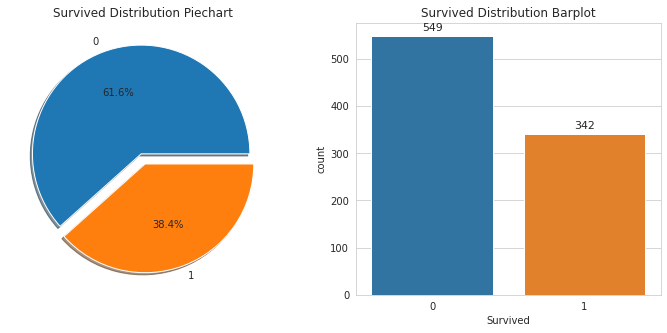

In [9]:
cat_dist(df_train,target)

Unfortunately, 61.6% or 549 passangers survived. What thing caused this accident? So, we will find out the thing by analyzing the data

## 2.2 Checking Predictor Distribution

### 2.2.1 Numerical

In [10]:
df_train[num_var].describe()

,SibSp,Parch,Age,Fare
count,891.000000,891.000000,714.000000,891.000000
mean,0.523008,0.381594,29.699118,32.204208
std,1.102743,0.806057,14.526497,49.693429
min,0.000000,0.000000,0.420000,0.000000
25%,0.000000,0.000000,20.125000,7.910400
50%,0.000000,0.000000,28.000000,14.454200
75%,1.000000,0.000000,38.000000,31.000000
max,8.000000,6.000000,80.000000,512.329200


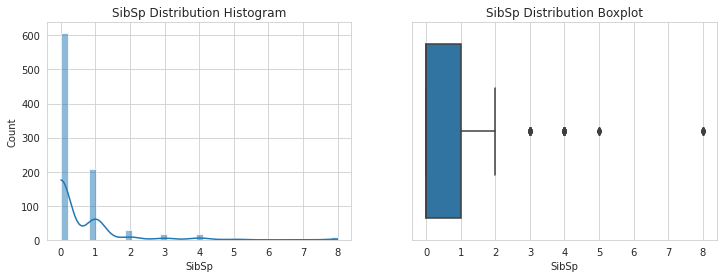

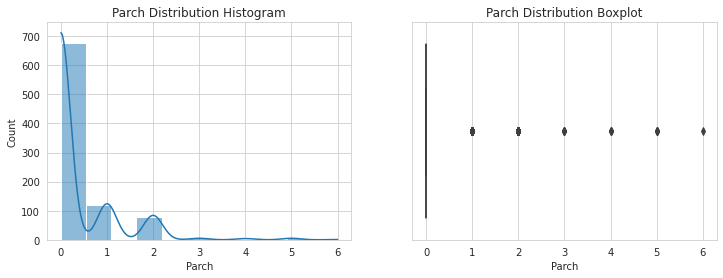

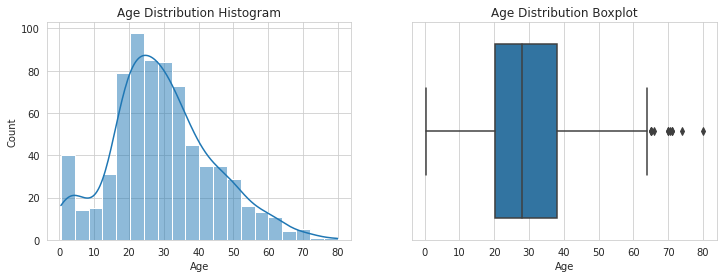

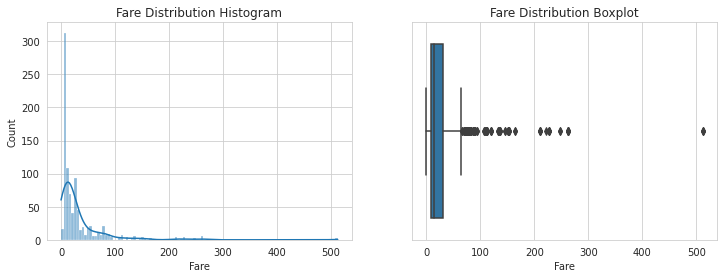

In [11]:
for var in num_var:
  num_dist(df_train,var)

We can see that only `Age` has a normal distribution but some outliers causes it to be skewed to the right. 

`SibSp` and `Parch` tell us that most of passengers traveled alone.

`Age` tell us the most passegers were 0.42 to 80 years old with average 28.

`Fare` tells us the passengers paid for ticket between 0 to 512.3 which is interesting because there is passernger who traveled without paying.



### 2.2.2 Categorical

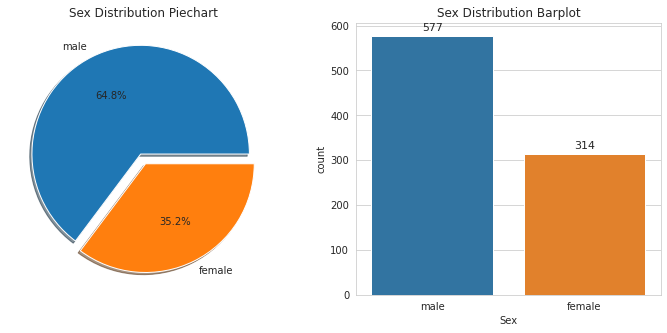

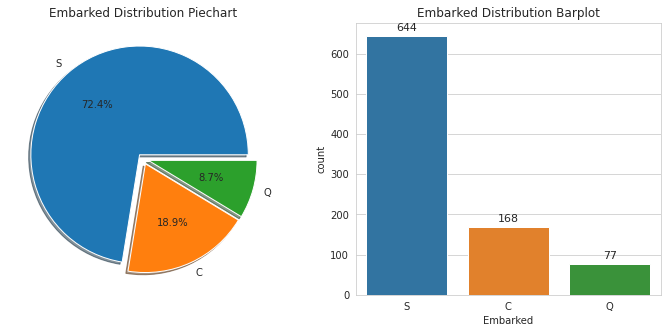

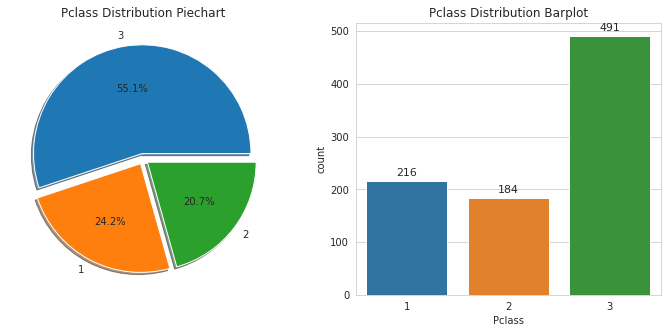

In [12]:
for var in cat_var:
  cat_dist(df_train,var)

We can see that:

- `Sex` tells us the most passengers dominated by male with 64.8%.

- `Embarked` tells us the passengers dominated from S with 72.4%, C with 18.9%, and Q with 8.7%.

- `Pclass` tell us the most passengers paid for ticket 3 with 55.1%, 1 with 24.2% and 2 with 20.7%


## 2.3 Survived Vs Not Survived

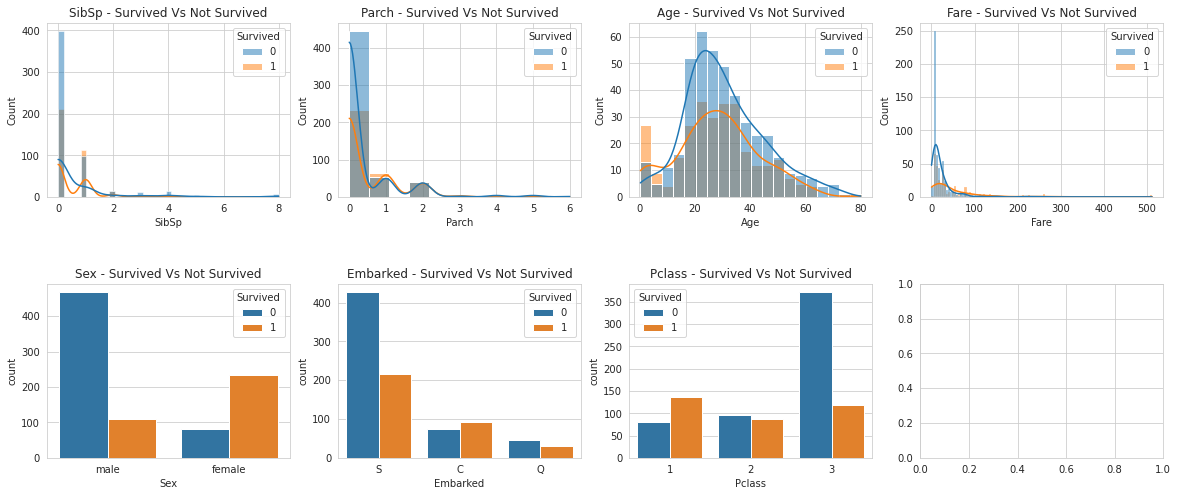

In [13]:
fig,ax=plt.subplots(2,4,figsize=(20,8))
ax=ax.flatten()

for i,var in enumerate(num_var+cat_var):
  if i < 4 :
    sns.histplot(x=var,data=df_train,kde=True,hue=target,ax=ax[i])
  else: sns.countplot(x=var,data=df_train,hue=target,ax=ax[i])

  ax[i].set_title(f'{var} - Survived Vs Not Survived')

plt.subplots_adjust(hspace=.5)
plt.show()

From visualization above we get:
- `SibSp` and `Parch` tell us passangers small amount of families have great chance to survive. 
- `Age` tells us children (<=10) have great chance to survive.
- `Sex` tells us that Female passengers have greate chance to survive than male
- `Embarked` tells us that passengers embarked from port C have greatest chance to survive than others
- `Pclass` tells us that passengers with class 1 have greatest chance to survive which are make sense that passangers class 1 have first priority to be rescued


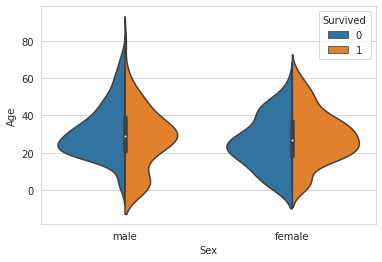

In [14]:
sns.violinplot(x='Sex',y='Age',data=df_train,hue='Survived',split=True)

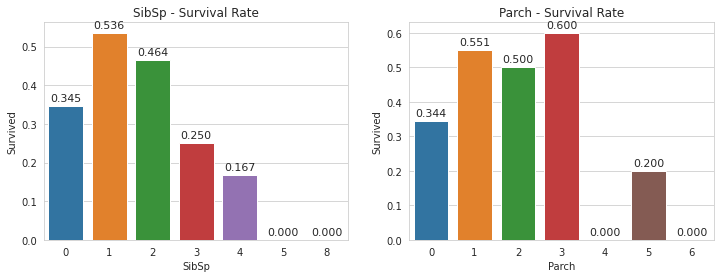

In [15]:
fig,ax=plt.subplots(1,2,figsize=(12,4))


for i,var in enumerate(['SibSp','Parch']):
  count=sns.barplot(x=var,y=target,data=df_train,ax=ax[i],ci=None )
  for bar in count.patches:
      count.annotate(format('{:.3f}'.format(bar.get_height())),
                     (bar.get_x()+bar.get_width()/2,bar.get_height()),
                     ha='center',
                     va='center',
                     size=11,
                     xytext=(0,8), 
                     textcoords='offset points'
                     )
  ax[i].set_title(f'{var} - Survival Rate')
plt.show()


The graph shown above tell us the passengers with small amount of families tend to survive. Meanwhile, there are only ~34% lone passangers (`SibSp` and `Parch` = 0) are survived. Unfortunately, passangers with `SibSp` > 4 have 0% to survive, and most passengers with `Parch` > 3 have 0% to survive.

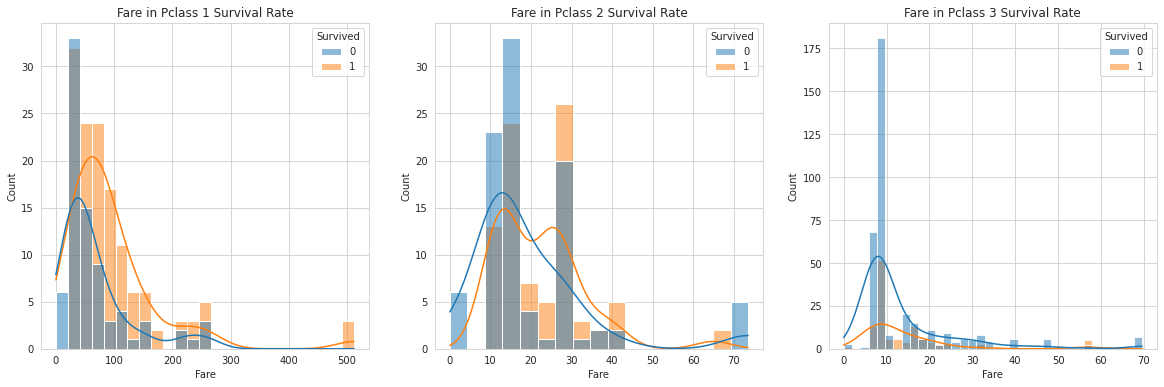

In [16]:
fig,ax = plt.subplots(1,3,figsize=(20,6))

for key,val in enumerate(sorted(df_train.Pclass.unique())):
  sns.histplot(x='Fare',data=df_train[df_train.Pclass == val],kde=True,hue=target,ax=ax[key])
  ax[key].set_title(f'Fare in Pclass {val} Survival Rate')

The passengers with higher `Fare` have great chance to survive, even though the highest `Fare` in `Pclass` 2 didn't survive. Most of the passengers in `Pclass` 3 didn't survive. Those 3 `Pclass` with lower `Fare` didn't survive.

# 3 Feature Engineering

## 3.1 PassengerId

In [17]:
df_train.PassengerId

0        1
1        2
2        3
3        4
4        5
      ... 
886    887
887    888
888    889
889    890
890    891
Name: PassengerId, Length: 891, dtype: int64

Because `PassengerId` is unique values and has no pattern within, we can drop it both in train and test data

In [18]:
df_train.drop('PassengerId',axis=1,inplace=True)
df_test.drop('PassengerId',axis=1,inplace=True)

## 3.2 Name

In [19]:
df_train.Name

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

We can see there are some pattern from passenger's name like Mr, Ms, etc. let see what they are

In [20]:
df_train['Title']=df_train.Name.str.extract('([A-Za-z]+)\.')
df_test['Title']=df_test.Name.str.extract('([A-Za-z]+)\.')


In [21]:
df_train.Title.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Title, dtype: int64

Some initials are owned by few people and some have same meanings to others. We need to group them into the same meaning

In [22]:
 def convert_title(title):
    if title in ['Miss','Mile','Ms']:
      return 'Miss'
    elif title in ['Mrs','Mme']:
      return 'Mrs'
    elif title in ['Mr']:
      return 'Mr'
    elif title == 'Master':
      return 'Master'
    else: return 'Other'


In [23]:
df_train.Title=df_train.Title.map(convert_title)
df_test.Title=df_test.Title.map(convert_title)


In [24]:
df_train.Title.value_counts()

Mr        517
Miss      183
Mrs       126
Master     40
Other      25
Name: Title, dtype: int64

Now we are done so we can drop `Name` variable in both train and test data

In [25]:
df_train.drop('Name',axis=1,inplace=True)
df_test.drop('Name',axis=1,inplace=True)

## 3.3 Ticket

In [26]:
df_train.Ticket

0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
             ...       
886              211536
887              112053
888          W./C. 6607
889              111369
890              370376
Name: Ticket, Length: 891, dtype: object

In [27]:
df_train.Ticket.nunique()

681

This variable has a lot unique values and no pattern to extract so we can drop it

In [28]:
df_train.drop('Ticket',axis=1,inplace=True)
df_test.drop('Ticket',axis=1,inplace=True)

## 3.4 Cabin

In [29]:
df_train.Cabin

0       NaN
1       C85
2       NaN
3      C123
4       NaN
       ... 
886     NaN
887     B42
888     NaN
889    C148
890     NaN
Name: Cabin, Length: 891, dtype: object

In [30]:
df_train.Cabin.value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

As we know before in [Checking Null Values](#scrollTo=1_3_Checking_Null_Values) that Cabin variable has a lot of missing values so we can drop it 

In [31]:
df_train.drop('Cabin',axis=1,inplace=True)
df_test.drop('Cabin',axis=1,inplace=True)

## 3.5 Age

In [32]:
df_train.Age

0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888     NaN
889    26.0
890    32.0
Name: Age, Length: 891, dtype: float64

We can see from [Checking Null Values](#scrollTo=1_3_Checking_Null_Values) that `Age` variable has small Null values so we need to perform imputation. Now, how do we do?

We can't just fill them with mean or median or mode because the data is big and we can't assign people 60 years with median 28. we need other method

let's check with their corelation to other variables

In [33]:
df_train.corr().Age.sort_values(ascending=False)

Age         1.000000
Fare        0.096067
Survived   -0.077221
Parch      -0.189119
SibSp      -0.308247
Pclass     -0.369226
Name: Age, dtype: float64

The corelation doesn't look good. We need to check it with categorical variable that might classify age of passengers. Probably `Title` variable

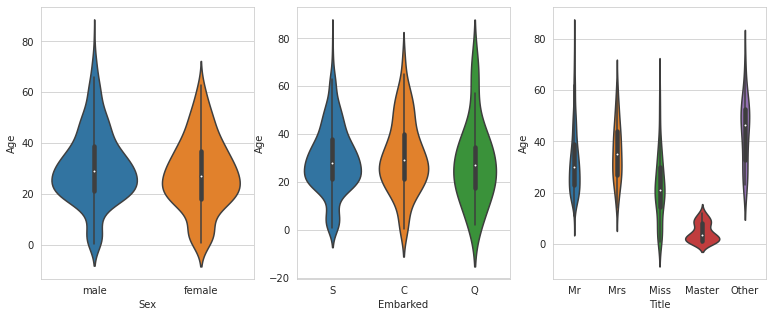

In [34]:
fig,ax=plt.subplots(1,df_train.select_dtypes('object').shape[1],figsize=(13,5))

for key,val in enumerate(df_train.select_dtypes('object').columns):

    sns.violinplot(x=val,y='Age',data=df_train,ax=ax[key])

`Title` variable is more detail to classify age of passengers which is good. So we use it to impute missing values

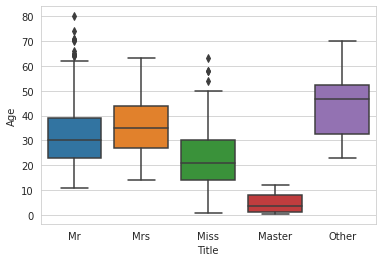

In [35]:
sns.boxplot(x='Title',y='Age',data=df_train)

`Age` in group by `Title` has 2 group contain outliers so we can use average to perform imputation

In [36]:
df_train.groupby('Title').Age.mean()

Title
Master     4.574167
Miss      21.816327
Mr        32.368090
Mrs       35.788991
Other     43.750000
Name: Age, dtype: float64

In [37]:
data=[df_train,df_test]

for df in data:
  df.loc[(df.Title == 'Master')&(df.Age.isnull()),'Age']=5
  df.loc[(df.Title == 'Miss')&(df.Age.isnull()),'Age']=22
  df.loc[(df.Title == 'Mr')&(df.Age.isnull()),'Age']=32
  df.loc[(df.Title == 'Mrs')&(df.Age.isnull()),'Age']=36
  df.loc[(df.Title == 'Other')&(df.Age.isnull()),'Age']=44


## 3.6 Fare

In [checking missing](#scrollTo=1_3_Checking_Null_values) value, we know that fare has 1 missing value in test data, so we will perform imputation but before that we need to check it's corelation to others.

In [38]:
df_train.corr().Fare

Survived    0.257307
Pclass     -0.549500
Age         0.092122
SibSp       0.159651
Parch       0.216225
Fare        1.000000
Name: Fare, dtype: float64

`Fare` variable looks good negative corelation with `Pclass` so we will check `Pclass` in missing value data.

In [39]:
df_test.loc[df_test.Fare.isnull()]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
152,3,male,60.5,0,0,NaN,S,Mr


`Pclass` of `Fare` missing value is 3. So we will impute missing value with mean of group of `Pclass` 3.

In [40]:
df_test.Fare.fillna(df_test.groupby('Pclass').mean().Fare[3],inplace=True)

## 3.7 SibSp and Parch

`SibSp` and `Parch` are explain that passengers are alone or not so we can create new variable name `Relative` that indicates whether passengers is alone or not by adding them and if the results has greater than 0 then we assign 1 into it if not then 0. 

In [41]:
for df in data:
  df['Relative']=df.SibSp + df.Parch
  df.loc[df.Relative > 0,'Alone']=1
  df.loc[df.Relative == 0,'Alone']=0

Since we have `relative` and `Alone`, `SibSp` and `Parch` can be dropped.

In [42]:
df_train.drop(['SibSp','Parch'],axis=1,inplace=True)
df_test.drop(['SibSp','Parch'],axis=1,inplace=True)

# 4 Feature Encoding And Scaling

In [43]:
ct=ColumnTransformer(
    [
        ('ohe',OneHotEncoder(),['Sex','Embarked','Title']),
        ('scaler',StandardScaler(),['Pclass','Age','Fare','Relative'])
    ]
)

# 5 Model Building

## 5.1 Splitting Dataset

,Pclass,Sex,Age,Fare,Embarked,Title,Relative,Alone
0,3,male,34.5,7.8292,Q,Mr,0,0.0
1,3,female,47.0,7.0000,S,Mrs,1,1.0
2,2,male,62.0,9.6875,Q,Mr,0,0.0
3,3,male,27.0,8.6625,S,Mr,0,0.0
4,3,female,22.0,12.2875,S,Mrs,2,1.0
...,...,...,...,...,...,...,...,...
413,3,male,32.0,8.0500,S,Mr,0,0.0
414,1,female,39.0,108.9000,C,Other,0,0.0
415,3,male,38.5,7.2500,S,Mr,0,0.0
416,3,male,32.0,8.0500,S,Mr,0,0.0


In [150]:
X_train=df_train.drop('Survived',axis=1)
y_train=df_train.Survived

X_test=df_test

## 5.2 Instantiate Classifiers

In [45]:
clf=LogisticRegression(max_iter=1000)
clf1=KNeighborsClassifier(n_jobs=-1)
clf2=RandomForestClassifier(n_jobs=-1)
clf3=SVC()
clf4=MLPClassifier(max_iter=1000)
clf5=XGBClassifier()
clf6=LGBMClassifier()

In [87]:
params={
    'classifier':[clf]

}

params1={
    'classifier':[clf1]
}

params2={
    'classifier':[clf2]
}

params3={
    'classifier':[clf3]
}

params4={
    'classifier':[clf4]
}
params5={
    'classifier':[clf5]
  
}
params6={
    'classifier':[clf6]
}
params=[params,params1,params2,params3,params4,params5,params6]

## 5.3 Instantiate Pipeline

In [83]:
pipe=Pipeline(
    [('processor',ct),('classifier',clf)]
)

## 5.4 Perform GridSearchCV

In [84]:
grid=GridSearchCV(pipe,params ,n_jobs=-1)

In [85]:
grid.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('processor',
                                        ColumnTransformer(transformers=[('ohe',
                                                                         OneHotEncoder(),
                                                                         ['Sex',
                                                                          'Embarked',
                                                                          'Title']),
                                                                        ('scaler',
                                                                         StandardScaler(),
                                                                         ['Pclass',
                                                                          'Age',
                                                                          'Fare',
                                                                          'Relative'])])),
             

In [108]:
results=pd.DataFrame(grid.cv_results_)[['param_classifier','mean_test_score','std_test_score','rank_test_score']].sort_values('rank_test_score').sort_values('rank_test_score')

results

,param_classifier,mean_test_score,std_test_score,rank_test_score
5,XGBClassifier(),0.833909,0.025170,1
3,SVC(),0.830525,0.025731,2
0,LGBMClassifier(),0.823803,0.026665,3
6,LGBMClassifier(),0.823803,0.026665,3
1,KNeighborsClassifier(n_jobs=-1),0.815963,0.016872,5
4,MLPClassifier(max_iter=1000),0.806993,0.019900,6
2,RandomForestClassifier(n_jobs=-1),0.806986,0.016898,7


In [109]:
results.param_classifier=results.param_classifier.astype('str')

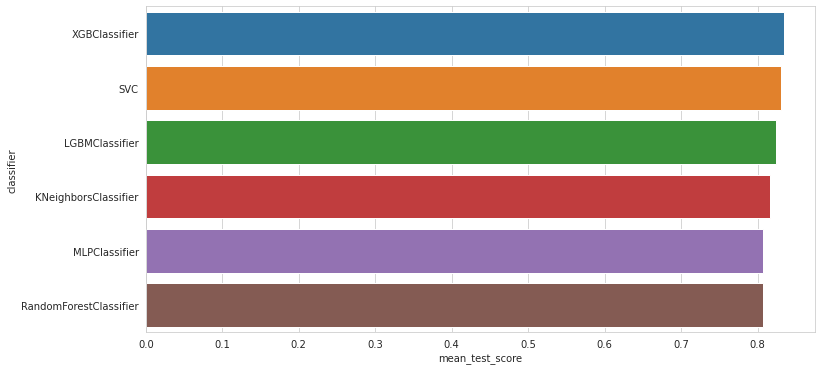

In [123]:
plt.figure(figsize=(12,6))
results['classifier']=results.param_classifier.str.extract('([A-Za-z]+)\(')
sns.barplot(x='mean_test_score',y='classifier',data=results)
plt.show()

In [125]:
grid.best_score_

0.8339087314041805

The XGBClassifier is best model with 83.3% accuracy so we choose it to be our model. Then we need to adjust it's parameter by performing hyper parameter tunning


## 5.5 Hyper Parameter Tunning

In [128]:
pipe=Pipeline(
    [('processor',ct),('XGBC',clf5)]
)

In [132]:
pipe.get_params()

{'memory': None,
 'steps': [('processor',
   ColumnTransformer(transformers=[('ohe', OneHotEncoder(),
                                    ['Sex', 'Embarked', 'Title']),
                                   ('scaler', StandardScaler(),
                                    ['Pclass', 'Age', 'Fare', 'Relative'])])),
  ('XGBC', XGBClassifier())],
 'verbose': False,
 'processor': ColumnTransformer(transformers=[('ohe', OneHotEncoder(),
                                  ['Sex', 'Embarked', 'Title']),
                                 ('scaler', StandardScaler(),
                                  ['Pclass', 'Age', 'Fare', 'Relative'])]),
 'XGBC': XGBClassifier(),
 'processor__n_jobs': None,
 'processor__remainder': 'drop',
 'processor__sparse_threshold': 0.3,
 'processor__transformer_weights': None,
 'processor__transformers': [('ohe',
   OneHotEncoder(),
   ['Sex', 'Embarked', 'Title']),
  ('scaler', StandardScaler(), ['Pclass', 'Age', 'Fare', 'Relative'])],
 'processor__verbose': False,
 'proce

In [134]:


params={
    'XGBC__learning_rate': [0.01, 0.6],
    'XGBC__subsample': [0.3, 0.9],
    'XGBC__max_depth': [3, 4, 5, 6, 7, 8, 9],
    'XGBC__colsample_bytree': [0.5, 0.9],
    'XGBC__min_child_weight': [1, 2, 3, 4]
}

grid=GridSearchCV(pipe,params,n_jobs=-1)
grid.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('processor',
                                        ColumnTransformer(transformers=[('ohe',
                                                                         OneHotEncoder(),
                                                                         ['Sex',
                                                                          'Embarked',
                                                                          'Title']),
                                                                        ('scaler',
                                                                         StandardScaler(),
                                                                         ['Pclass',
                                                                          'Age',
                                                                          'Fare',
                                                                          'Relative'])])),
             

In [139]:
grid.best_params_

{'XGBC__colsample_bytree': 0.9,
 'XGBC__learning_rate': 0.6,
 'XGBC__max_depth': 3,
 'XGBC__min_child_weight': 4,
 'XGBC__subsample': 0.9}

# 6 Model Evaluation

In [147]:
print(f'Accuracy Score CV:{grid.best_score_}')


Accuracy Score CV:0.8473793233318686


In [152]:
y_pred=grid.predict(X_test)
y_pred

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,

The model performance increases from 83.3% to 84.7% which is good.

# 7 Submit as .csv File


In [155]:
submission=pd.read_csv('/content/drive/MyDrive/Datasets/titanic/gender_submission.csv')
submission.Survived=y_pred
submission.to_csv('/content/drive/MyDrive/Datasets/titanic/submission.csv')


# 8 Future Works
This project didn't perform Imbalance Data Checking in Feature Engineering so hopefully in the future research will perform Imbalance Data Checking. All feedbacks are welcome.
